# Homework 2 (HW2)

By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in `sklearn`;
- Carry out simple multivariate regression analyses using `statsmodels`;
- Use propensity score matching to estimate treatment effects;

---

## Important Dates

- Homework release: Fri 15 Nov 2024
- **Homework due**: Fri 29 Nov 2024, 23:59
- Grade release: Mon 09 Dec 2024

---

##  Some rules

1. You are allowed to use any built-in Python library that is included in the `requirements.txt` for this homework. If you use any additional library, this may complicate the grading process, and we reserve the right to penalize your grade for unnecessary complexity of the solution. All the questions can be solved with the libraries in `requirements.txt`.
2. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, we will **not grade** anything.
3. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
4. In continuation to the previous point on additional library, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!

**A Note on using Language Models (LMs)**

If you try hard enough, you will likely get away with cheating. Fortunately, our job is not to police, but rather to educate! So, please consider the following:

Presumably, you are taking this course to learn something! LMs are not always right ([they often fail in silly ways](https://community.openai.com/t/why-9-11-is-larger-than-9-9-incredible/869824/4)). This course should prepare you to detect when they are wrong!
Some of the TAs on this course literally published many works on detecting machine-generated text.

Here LLM includes but not limited to chatbots like ChatGPT, coding assistants like Copilot. Do not even use them to prettify your code or correct English. If you are caught using LLMs, you will be reported to the instructor and subject to the consequences. 


---


## Grading 
- The homework has a total of 100 points, distributed as follows:
    - Part 1: Data Preprocessing ( 20 points)
    - Part 2: Linear Regression (30 points)
    - Part 3: Supervised Learning (40 points)
    - Part 4: Propensity Score Matching (10 points)

## Context

Within EPFL's master program, you are excited to start an internship as a data scientist.
After rounds of interviews, you have been selected to work with the biggest car dealership in Switzerland !

Your mentor at the company Tim, has explained to you that the company is interested in a pricing model for used cars. 

- Tim: "We have a lot of used cars in our inventory, and we need to determine the price at which we should sell these cars. We have some ideas about the factors that influence the price of a used car, but so far we have just been using our experience and intuition to determine the price of a used car. Sometimes it works, but probably we can do better and a more data-driven approach would also help our new employees in the sales team as they have less experience."

- You: "That sounds like a great project! What kind of data do we have?"

- Tim: "We sell all kinds of cars here, but maybe we can start with a specific brand and model. For example, the Toyota Corolla is the best-selling car worldwide in 2023, and we have a lot of data on it. We can start by analyzing the data on used Toyota Corolla cars. If it works well, we can extend the analysis to other brands."

The dataset contains the following columns:

- `Age`: Age of the car in months.
- `Mileage`: Number of distance the car has been driven. (km or miles)
- `FuelType`: Fuel type of the car (Petrol, Diesel, or CNG)
- `HP`: Horsepower
- `MetColor`: Is the color of the car metallic? (Yes=1, No=0)
- `Automatic`: Is the car automatic? (Yes=1, No=0)
- `CC`: Cylinder volume in cubic centimeters
- `Doors`: Number of doors
- `Weight`: Weight of the car in kilograms
- `Price`: Price of the car in euros


## Data

The data is provided in the `data` folder and it contains the following 3 csv files:
- `Task1-2.ToyotaCorolla-clean.csv` and `Task1-2.ToyotaCorolla-raw.csv` for Part 1 and Part 2
- `Task3.ToyotaCorolla_sales_3months.csv` for Part 3
- `Task4.ToyotaCorolla_discount_sales` for Part 4

You should not use any other data source for this homework.

## References:

The data is based on the ToyotaCorolla dataset from the UCI Machine Learning Repository [here](https://archive.ics.uci.edu/ml/datasets/Toyota+Corolla).
We have made some modifications to the original dataset, so please use the data provided in the `data` folder in the course repo.

## Task 1 (20 pts) - Get to know the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
import sklearn

# fix random seed for reproducibility
np.random.seed(42)
random.seed(42)

import seaborn as sn
import scipy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


**1.1 (2 pts)**: Load the data from the file `Task1-2.ToyotaCorolla-raw.csv` into a pandas DataFrame. Display the first 5 rows of the DataFrame. Hint: A naive loading of the data will raise an error. You will need to figure out how to load the data correctly. (Hint: localise which row is causing the error)

There is a single bad line containing 12 columns instead of 11 in row 33 : 
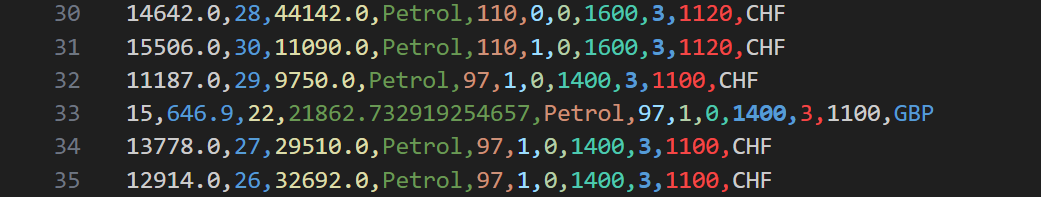

The value 15,646.9 for the "price" uses a comma as a *thousands separator*, which conflicts with the CSV delimiter (also a comma). This causes the parser to incorrectly treat this as two separate columns, breaking the structure of the file.
We fix this row by restoring the correct Price value by removing the *thousands separator* using the fix_bad_row function.

In [ ]:
def fix_bad_row(bad_row) :
    bad_row[0] = bad_row[0] + bad_row[1]
    bad_row.pop(1)
    return bad_row
    
df_corolla_raw = pd.read_csv('./data/Task1-2.ToyotaCorolla-raw.csv',on_bad_lines=fix_bad_row, engine='python')
df_corolla_raw.head(5)

**1.2 (2 pts)**: Check if there are nan values in the Dataframe. If there are, try to find out which row is problematic and fix it. If you can't fix it, drop the row.

In [ ]:
df_corolla_raw[df_corolla_raw.isna().any(axis=1)]

In [ ]:
problematic_row = df_corolla_raw[df_corolla_raw.isna().any(axis=1)].index[0]
print(f"The problematic row is the {problematic_row}th row which has ';' as separator instead of ','.")

In [ ]:
def str_to_float(s):
    try:
        return np.float64(s)
    except (ValueError, TypeError):
        return s

df_corolla_raw.iloc[problematic_row] = [str_to_float(s) for s in df_corolla_raw.iloc[problematic_row]["Price"].split(";")]
df_corolla_raw.iloc[problematic_row]

In [ ]:
if not df_corolla_raw.isnull().values.any(): 
    print('There are no more NaN values in the dataset')

**1.3 (4 pts): Compute the mean, median of the `Price` column.**

1. Compute the mean and median of the `Price` column. If you encounter error, try to understand why this error is happening and propose a solution.
2. After computing the mean and median, do you think they are reasonable? If not, what could be the reason for this? 
  
Hint: Is all values in the `Price` column numerical?


- Some prices are **strings**, we will convert all prices to *float64* to avoid errors.  
- Certain strings also have a **','** between the thousands and the hundreds which we will remove to get the correct float value.  
- Some prices also end by the symbol **'£'**, like '7,898.2£', which we also remove to avoid problems with the casting to float values.

In [ ]:
def price_str_to_float(s):
    if type(s) == str:
        
        if s.endswith("£"):
            s = s[:-1]
            
        if s.count(",") == 2: # there is a string with two ',' one for the thousands and hundreds separation and another one for the decimal part instead of a '.'
            s = s.rsplit(',', 1)[0] + '.' + s.rsplit(',', 1)[1] # replace last ',' by '.'

        return np.float64(s.replace(",", ""))
    else :
        return s

df_corolla_raw["Price"] = df_corolla_raw["Price"].apply(price_str_to_float)

In [ ]:
df_corolla_raw["Price"].describe()

In [ ]:
print(f'The mean price is {df_corolla_raw["Price"].mean():.1f} and the median price {df_corolla_raw["Price"].median()}')
print('The results seems coherent for car prices.')
print('However, the prices are in different currencies, which we will need to convert to get the correct statistics.')

In [ ]:
print(f"Note also that the Mileage column contains a string that starts with 'ß'. It should be fixed if using the Mileage column.")
df_corolla_raw[df_corolla_raw["Mileage"].apply(lambda x: str(x).startswith("ß"))]

**1.4 (4 pts): Convert Units**

From now on, we will work with the cleaned data `Task1-2.ToyotaCorolla-clean.csv`. Read it into a DataFrame.

You notice that some prices are in CHF (Swiss Francs), while others are in EUR (Euros) or GBP (British Pounds). Additionally, for cars priced in GBP, the mileage is in miles rather than kilometers.

For consistency, convert all prices to CHF and all distances to kilometers.

- Exchange rates:
  - 1 CHF = 1.05 EUR
  - 1 GBP = 1.15 CHF
  - 1 mile = 1.61 km

Make the following conversions:
1. Convert prices in EUR or GBP to CHF, rounding to the nearest integer.
2. Convert distances in miles (for GBP cars) to kilometers, rounding to the nearest integer.
3. Drop the 'Currency' column.
4. Calculate the min, mean, median and max of the 'Price' and 'Distance' columns after the conversion.

In [ ]:
df_corolla_clean = pd.read_csv('./data/Task1-2.ToyotaCorolla-clean.csv')

def convert_to_km(row):
    # Convert mileage to km if the currency is GBP + rounding to the nearest integer
    if row['Currency'] == 'GBP':
        return round(row['Mileage'] * 1.61)
    return round(row['Mileage'])

df_corolla_clean['Mileage'] = df_corolla_clean.apply(convert_to_km, axis=1)

def convert_to_CHF(row):
    # Converts price to CHF from EURO or GBP + rounding to the nearest integer
    if row['Currency'] == 'EURO':
        return round(row['Price'] / 1.05)
    elif row['Currency'] == 'GBP':
        return round(row['Price'] * 1.15)
    return round(row['Price'])

df_corolla_clean['Price'] = df_corolla_clean.apply(convert_to_CHF, axis=1)
df_corolla_clean = df_corolla_clean.drop('Currency', axis=1)

In [ ]:
df_stats = df_corolla_clean[['Price', 'Mileage']].agg(['min', 'mean', 'median', 'max'])
df_stats

**1.5 (2 pts): Analyze Average Price**

A.  Print the average price for each fuel type. Determine which fuel type has the highest average price.

B.  Print the average price for different numbers of doors. Determine which number of doors has the highest average price.

In [ ]:
df_corolla_clean.groupby('FuelType')['Price'].agg('mean')

In [ ]:
df_corolla_clean.groupby('Doors')['Price'].agg('mean')

- The fuel type with the highest average price is diesel. 
- And for the numbers of doors is 5.

*(Extra) We also observed that cars with 5 doors and Diesel combined also have the highest average price. 
But followed very closely by the combination of CNG and 4 doors.*

In [ ]:
df_corolla_clean.groupby(['Doors','FuelType'])['Price'].agg('mean')

**1.6 (2 pts): Relationship Between Car Age and Price**

It is intuitive that an older car tends to be cheaper, and a car with more mileage might also be less expensive. 

To explore this intuition, create two scatter plots:
1. Car Age vs Price
2. Mileage vs Price

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.scatterplot(df_corolla_clean, x='Age', y='Price', color='#3c5d88')
plt.ylabel('Price (CHF)')

plt.subplot(122)
sn.scatterplot(df_corolla_clean, x='Mileage', y='Price', color='#6b0a0a')
plt.ylabel('Price (CHF)')
plt.xlabel('Mileage (Km)')

plt.suptitle('Scatterplot of Price over Age and Mileage')
plt.tight_layout()
plt.show()

**1.7 (4 pts): Correlation Between Price and Mileage**

The relationship between car price and mileage appears non-linear, with a steeper price drop initially followed by a flatter curve.

A.(2 pts)  Calculate both the Pearson and Spearman correlations between the price of the car and the distance driven.


In [ ]:
pearson, p_pearson = scipy.stats.pearsonr(df_corolla_clean['Mileage'], df_corolla_clean['Price'])
spearman, p_spearman = scipy.stats.spearmanr(df_corolla_clean['Mileage'], df_corolla_clean['Price'])
print(f'The Pearson correlation between the price of the car and the distance driven is {pearson:.3f} with p-value {p_pearson}')
print(f'The Spearman correlation between the price of the car and the distance driven is {spearman:.3f} with p-value {p_spearman}')


B.(2 pts)  Which correlation value is higher? Does this result align with your expectations?

- The Spearman correlation is larger in magnitude, which is the expected result because the distribution is more monotonic than linear. Indeed, while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not). In the scatterplot we can see that the Price generally decreases with increasing Mileage, although not linearly, which explains why the Spearman correlation is larger in absolute.
- The p-value is also lower for Spearman, showing that monotonicity is a better assumption than linearity for this sample.

## Part 2 Linear Regression (30 pts)

You want to build a linear regression model to predict the price of a car based on the features you have.



**2.0 (8 pts) Helper functions**

Before building machine learning models, how to asses performance is crucial. Hence we first implement some helper functions to asses the performance of our model. We can use these later throughout the exercise.

Implement the `accuracy` , `precision`, `recall` and `f1_score` functions with the following requirements:

1. These functions should take in the true labels(`np.array`) and the predicted labels(`np.array`) and return the corresponding metric. 
2. They should follow the convention that the positive class is 1 and the negative class is 0.
3. Apply the functions to the following data:

```python
true_labels = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])
predicted_labels = np.array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])
```

Compare the results with the implementation in `sklearn` and see if they match.

In [ ]:
def accuracy(true_labels, predicted_labels):
    # Accuracy = correct predictions / total predictions
    correct = np.sum(true_labels == predicted_labels)
    total = len(true_labels)
    return correct / total

def precision(true_labels, predicted_labels):
    # Precision = TP / (TP + FP)
    tp = np.sum((true_labels == 1) & (predicted_labels == 1))
    fp = np.sum((true_labels == 0) & (predicted_labels == 1))
    return tp / (tp + fp) if (tp + fp) != 0 else np.NaN

def recall(true_labels, predicted_labels):
    # Recall = TP / (TP + FN)
    tp = np.sum((true_labels == 1) & (predicted_labels == 1))
    fn = np.sum((true_labels == 1) & (predicted_labels == 0))
    return tp / (tp + fn) if (tp + fn) != 0 else np.NaN 

def f1(true_labels, predicted_labels):
    # F1-score is the harmonic mean of precision and recall
    prec = precision(true_labels, predicted_labels)
    rec = recall(true_labels, predicted_labels)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else np.NaN 

In [ ]:
def test_metrics():
    true_labels = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])
    predicted_labels = np.array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

    # Calculate metrics using our functions
    accuracy_val = accuracy(true_labels, predicted_labels)
    precision_val = precision(true_labels, predicted_labels)
    recall_val = recall(true_labels, predicted_labels)
    f1_val = f1(true_labels, predicted_labels)

    print("The values of the metrics computed with our functions are:")
    print(f"Accuracy: {accuracy_val:.4f}")
    print(f"Precision: {precision_val:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"F1-Score: {f1_val:.4f}")
    
    # Calculate metrics using sklearn
    sklearn_accuracy = accuracy_score(true_labels, predicted_labels)
    sklearn_precision = precision_score(true_labels, predicted_labels)
    sklearn_recall = recall_score(true_labels, predicted_labels)
    sklearn_f1 = f1_score(true_labels, predicted_labels)

    print("\nThe values of the metrics computed with sklearn are:")
    print(f"Accuracy: {sklearn_accuracy:.4f}")
    print(f"Precision: {sklearn_precision:.4f}")
    print(f"Recall: {sklearn_recall:.4f}")
    print(f"F1-Score: {sklearn_f1:.4f}")
    
    # Check if all results match
    assert np.isclose(accuracy_val, sklearn_accuracy), f"Accuracy mismatch: {accuracy_val} != {sklearn_accuracy}"
    assert np.isclose(precision_val, sklearn_precision), f"Precision mismatch: {precision_val} != {sklearn_precision}"
    assert np.isclose(recall_val, sklearn_recall), f"Recall mismatch: {recall_val} != {sklearn_recall}"
    assert np.isclose(f1_val, sklearn_f1), f"F1-Score mismatch: {f1_val} != {sklearn_f1}"

    print("\nAll tests passed successfully.")

test_metrics()


**2.1 (6 pts) Preprocess the Data**

To prepare your data for building a linear regression model, complete the following steps:

A.(1 pts) Convert the categorical variables to one-hot encoding using the `pd.get_dummies()` function, how many columns do you have after the one-hot encoding? (P.S. You may want to avoid introducing multicollinearity with one-hot encoding, what should you do to avoid this?)


In [ ]:
print(f"There are 4 categorical variables :")
print(f"- 'FuelType' with 3 possible categories : {df_corolla_clean['FuelType'].unique()}")
print(f"- 'Doors' with 4 possible categories : {df_corolla_clean['Doors'].unique()}. Indeed, even if the values are numerical, they represent distinct categories or groups rather than a continuous numeric quantity. ")
print(f"- 'Automatic' and 'MetColor' are also categorical but they are binary, so we can use them as they are.")

In [ ]:
df_corolla_clean = pd.get_dummies(df_corolla_clean, columns=['FuelType', 'Doors'], drop_first=True, dtype=int)
df_corolla_clean.head(5)

Multicolinearity occurs if you have for instance 3 categories and get 3 dummy columns for each of the categories.
In that case, the third column is a linear combination of the first 2, as it necessarily has value 1 where both of the other columns have value 0.
- To avoid this, we one-hot encode only N-1 columns for N categories using the *drop_first* parameter in pandas'`get_dummies()`.

B.(1 pts) Split the data into features (X) and target (y) variables. The target variable is the 'Price' column. Then split the data into train test sets using a 80-20 split. Use `random_state=42` for reproducibility. How many samples are in the training set and how many samples are in the test set?


In [ ]:
X = df_corolla_clean.drop('Price', axis=1)
y = df_corolla_clean['Price']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

C.(1 pts) Why do we split the data into only train-test sets but not train-validation-test sets? 

Because we if we split further the data, we have less data to train the model and therefore we will loss predictive power. 
Instead if needed we can use others methods such as cross-validation. Furthermore, a validation set is useful for finetuning hyperparameters of models using a loss function, which is not needed for Ordinary Least Squares.

D.(1 pts) **Standardize the Features**: Use `StandardScaler` from `sklearn.preprocessing` and then add a constant column using `sm.add_constant()`. Print the average and standard deviation of the training set after standardization.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# We fit the scaler on the training set to use the same mean and variance of the training for the test set
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)
# Add a constant column to the training and test set
X_train_st = sm.add_constant(X_train_st)
X_test_st = sm.add_constant(X_test_st)

mean_train = X_train_st.mean(axis=0)
std_train = X_train_st.std(axis=0)

print("Train set average and standard deviation after standardization:",)
result_mean_std = pd.DataFrame({'Feature': ["Constant"] + list(X.columns), 'Mean': mean_train, 'Standard Deviation': std_train})
result_mean_std

E.(2 pts) Should we first standardize the data and then split it into train and test sets or vice versa?   why?

We need to first split the data into train and test because we need to standardize the test set with the mean and standard deviation from the training set.
- It is important to avoid data leakage: if we first standardize and then split, the training set contains statistical information about the test set and vice versa, which may cause bias and inaccurate test performance. This ensures that the test set remains truly independent. 
- As the model is trained on standardised training data (thus standardised with values of the training set), it is then important to scale the test data in the same way, to give the model data in the same range.

**2.2 (10 pts) Train and Evaluate the Linear Regression Model**

To train and evaluate a linear regression model using the `statsmodels` library, complete the following steps:

1. (2 pts) Train a linear regression model on the training dataset using `sm.OLS` from `statsmodels`, print the summary of the model using `model.summary()`.


In [ ]:
# For interpretability, let's add back the column names to the data
X_train_st = pd.DataFrame(X_train_st, columns=['Constant']+X.columns.tolist())
y_train = y_train.reset_index(drop=True)
X_test_st = pd.DataFrame(X_test_st, columns=['Constant']+X.columns.tolist())
y_test = y_test.reset_index(drop=True)

In [ ]:
model = sm.OLS(y_train, X_train_st)
results = model.fit()
print(results.summary())

2. (2 pts) Evaluate the model on the test dataset using the square root of the mean squared error (RMSE) metric. 
   1. Report the RMSE value.
   2. Your boss wants to know how far off the model's predictions are from the actual price of the car. What would you tell him? Given a number and explain how you got it.


In [ ]:
from sklearn.metrics import mean_squared_error

predictions = results.predict(X_test_st)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'The RMSE of the model is {rmse:.2f}')

The $RMSE$ measures the average difference between values predicted by a model and the actual values. It provides an estimation of how well the model is able to predict the target value. It can also be interpreted as the standard deviation of the error: in our case this means that the model is on average about 1434.34 CHF off on the price prediction.

To get a better feeling of the magnitude of the $RMSE$ compared to the mean we can also analyse the coefficient of variation $CV=\frac{\text{RMSE}}{\hat \mu}$, where $\hat \mu$ is the mean estimate. The $CV$ gives a *proportional* information of the dispersion compared the the distribution mean. 

The $RMSE$ and $CV$ therefore are meaningul values to know *"how far off the model's predictions are from the actual price of the car"*, as it shows the absolute and proportional extents of variability of the models predictions compared to the actual car prices.

In [ ]:
print(f"The predicted average price of a car is {y.mean():.2f}CHF with a RMSE of {rmse:.2f}CHF, it implies a relative error of {(rmse / y.mean())*100:.2f} % on average.")

3. (2 pts) Report the R² score on the test dataset and interpret it.

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f'The R2 score of the test dataset is {r2:.2f}')

This mean that 81% of the variability on the car prices is explained by the model, the remaining percentage is due to unobserved covariates or random noise.

4.  (2 pts) Which features are statistically significant at a 5% significance level? 

From the $P>|t|$ column in *OLS Regression results*, the significant features are **Age**, **Mileage**, **HP**, **CC**, **Weight** and the **Fuel Type dummies**

We can observe their p-values below:

In [ ]:
pvals = results.pvalues
print(f'{pvals[pvals<0.05]}')

- While the **constant** term is statistically significant, it should not be considered a feature as it does not represent a real predictor in the model. 

5.  (2 pts) Determine which two feature have the highest coefficient? What does it imply?

By excluding the *constant* term as we did it above, we observe that **Age** and **Weight** have the coefficients that are largest in absolute value, with value:

In [ ]:
coefficients = results.params
magnitude_sorted_coeffs = coefficients.abs().sort_values(ascending=False).index
print(coefficients[magnitude_sorted_coeffs][:3])

The two features with the highest coefficient therefore are **Age** and **Weight**.  
 
The implications are that:
- When **Age** increases and all other parameters stay fixed, the *price* decreases rapidly.
- When **Weight** increases and all other parameters stay fixed, the *price* increases rapidly.

**2.3 (2 pts): Improvement Discussion**

- Suggest a few additional features that could potentially explain this remaining variance in the data ( at least 2 features).

Other features that could explain the remaining variance in the data are:
- A boolean variable **Accidented** if the car had a crash previously.
- A categorical variable **Additional Features** which contains a list of extra features such as a GPS, sound system, voice control, speed control,...
- A continuous variable **Fuel Efficiency**, which gives the kilometers per litre the car can achieve.

**2.4 (2 pts): Identifying Confounding Variables**

The feature "Weight" shows a very low p-value and a high coefficient, but it doesn't seem to be a major factor for customers buying a second-hand car. You go to your mentor Tim to discuss this issue. Indeed, Tim suggests that never in his career has he seen a customer who asked for the weight of a car before buying it.
You suspect that there might be a confounding variable that is correlated with the car's weight and significantly influences its price.

- Suggest a possible confounding variable that may be correlated with the car's weight and significantly influence its price (it doesn't need to be a variable in the dataset). Explain why this variable could be a confounding variable.

A confounding variable could be whether the car is a **SUV**. This class of vehicles is known to be **both** *heavier* and more *expensive*.  
This factor would therefore explain the increase in price observed with the increase in weight and size.  

In other words, the weight variable is correlated with the car being a SUV, which is known to be correlated with cars' price.  
This chain of correlations explains the low p-value for the **Weight** feature and the possible confounding with an *intuitive intermediary variable.*

**2.5 (2 pts): Adding an Inverse Mileage Term**

From the previous scatter plot, the relationship between car price and mileage appears non-linear, with a steep price drop initially and then a flattening. A suitable approach to model this behavior is by incorporating an inverse term of mileage.

- Add the inverse mileage term to the model and retrain it using the code provided. Print the model summary and interpret the effect of the inverse mileage term.
  

In [ ]:
X_2 = df_corolla_clean.drop('Price', axis=1)
y_2 = df_corolla_clean['Price']

X_2['Inv_Mileage'] = 1 / X_2['Mileage']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

# We fit the scaler on the training set to use the same mean and variance of the training for the test set
X_train_st_2 = scaler.fit_transform(X_train_2)
X_test_st_2 = scaler.transform(X_test_2)

# Add a constant column to the training and test set
X_train_st_2 = sm.add_constant(X_train_st_2)
X_test_st_2 = sm.add_constant(X_test_st_2)

# For interpretability, let's add back the column names to the data
X_train_st_2 = pd.DataFrame(X_train_st_2, columns=['Constant']+X_2.columns.tolist())
y_train_2 = y_train_2.reset_index(drop=True)
X_test_st_2 = pd.DataFrame(X_test_st_2, columns=['Constant']+X_2.columns.tolist())
y_test_2 = y_test_2.reset_index(drop=True)

In [ ]:
model2 = sm.OLS(y_train_2, X_train_st_2)
results2 = model2.fit()
print(results2.summary())

The coefficient for the **Inverse Milieage** trem is -70.14 with a p-value of 0.062 above the 0.05 threshold for statistical significance. Additionaly, the R-squared value remains unchanged, indicating that the overall explanatory power of the model has not improved.

Despite this, the coefiecient values effectively model the non-linear relationship between car price and mileage:

The negative coefficient means that when **Inverse Milieage** increases (low **Mileage**) and all other parameters stay fixed, the *price* decreases.  
While this may seem counterintuitive at first because we generally expect low mileage to correlate with higher prices (as seen before with **Mileage**).  

- This effect complements the **Mileage** coefficient *(−511.68)*:
    - At low mileage: **Inverse Mileage** is large and influence prediction to model the steep initial price drop.
    - At high mileage: **Inverse Mileage** approaches zero and its impact becomes negligible, leaving the **Mileage** term to dominate and capture the leveling-off effect in prices.

In others words: 
- **Mileage** models the steep price decline as mileage increases.
- **Inverse Mileage** adjusts for the flattening of price at higher mileage values by disappearing as its influence diminishes.

This combination enables the model to represent both the sharp initial decline and the gradual leveling-off of prices, effectively capturing the observed non-linear behavior.

## Part 3 Supervised Learning (40 pts)


After completing your analysis, you're satisfied with the results. You handed the Jupyter notebook over to your mentor.

(Fun fact: The name "Jupyter" is derived from Julia, Python, and R—three programming languages that the platform was originally designed for.)

Your mentor Tim is very impressed with your work and asks you the following question:

“
This looks great! It will be very useful for our sales team. While looking at the results, I realized that there might be one thing that we can improve. 
For companies like us, it is important to sell the cars quickly. If we are patient, we might be able to sell the car for a higher price, but that’s not always the best strategy. We need to consider the maintenance costs for the car, the cash flow and the fact that the price of the car decreases over time."

He then continues:
"Three months is a sweet spot for us. If we can sell the car within the first three months, it is great. If not, it is worth considering lowering the price to sell it faster and increase our cash flow. I can ask Ivan from Sales to collect data in the last few months on whether the car was sold within the first three months or not. This would be great if you could have a model that tells us if the car will be sold in the first three months or not. "

This sparks your interest, and soon Ivan has provided you with the new data containing an additional column `sold_within_3_months` which is a binary variable indicating whether the car was sold within the first three months or not.

Note: The data for this part is in the file `Task3.ToyotaCorolla_sales_3months.csv` and it has already unified the currency and distance units.

In [ ]:
data_df = pd.read_csv('data/Task3.ToyotaCorolla_sales_3months.csv', index_col=0)
data_df.head()


**3.1 (2 pts): Preprocess the Data**
1. （1 pts）How many cars in the dataset were sold in the first three months, and how many were not? 

In [ ]:
sold3months = data_df['sold_within_3_months'].value_counts()
print(f'There were {sold3months.loc[1]} cars sold in the first 3 months and {sold3months.loc[0]} cars that were not.')

2. (1 pts) Preprocess the categorical variables to one-hot encoding using the `pd.get_dummies()` function.

In [ ]:
data_df = pd.get_dummies(data_df, columns=['FuelType', 'Doors'], drop_first=True, dtype=int)
data_df

**3.2 (20 pts): Logistic Regression Model**

1. (2 pts) Split the data into features (X) and target (y) variables. The target variable is the 'sold_within_3_months' column. The `Price` column should be included as a feature.

In [ ]:
X = data_df.drop('sold_within_3_months', axis=1)
y = data_df['sold_within_3_months']

2. (2 pts) Then split the data into train test sets using a 80-20 split. Use `random_state=42` for reproducibility. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

3. (2 pts) Standardize the features using `StandardScaler` from `sklearn.preprocessing` and then add a constant column using `sm.add_constant()`.

In [ ]:
# We fit the scaler on the training set to use the same mean and variance of the training for the test set
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# Add a constant column to the training and test set
X_train_st = sm.add_constant(X_train_st)
X_test_st = sm.add_constant(X_test_st)

# For interpretability, let's add back the column names to the data
X_train_st = pd.DataFrame(X_train_st, columns=['Constant']+X.columns.tolist())
y_train = y_train.reset_index(drop=True)
X_test_st = pd.DataFrame(X_test_st, columns=['Constant']+X.columns.tolist())
y_test = y_test.reset_index(drop=True)

4. (2 pts) Fit a logistic regression model on the training dataset.

The model upon fitting outputs the following message:
``` 
Possibly complete quasi-separation: A fraction 0.17 of observations can be perfectly predicted. This might indicate that there is complete quasi-separation. 
```
In the case of complete quasi-separation using Logistric regression, there is the risk that weights do not converge and go to infinity. We indeed observed this behaviour and therefore introduced L1-regularisation to stabilise the training. With regularisation, there are no longer any convergence warnings and the accuracy metrics slightly improved.

In [ ]:
log_reg = sm.Logit(y_train, X_train_st).fit_regularized(method='l1', alpha=1.0, maxiter=1000)
print(log_reg.summary())

5. (2 pts) Evaluate the model on the test dataset using the accuracy score metric. Report the accuracy score.

In [ ]:
y_pred_prob = log_reg.predict(X_test_st)
y_pred = y_pred_prob > 0.5
print(f'The accuracy on the test set is {accuracy(y_test, y_pred):.3f}')

6. (2 pts) Calculate the precision, recall, and F1-score.

In [ ]:
print(f'The precision is {precision_score(y_test, y_pred):.3f}')
print(f'The recall is {recall_score(y_test, y_pred):.3f}')
print(f'The F1-score is {f1_score(y_test, y_pred):.3f}')


7. (2 pts) Suppose that your company is running short on cash flow and needs to sell the cars quickly. How should you adjust the threshold for the logistic regression model to ensure that the company can sell the cars as quickly as possible?
    - A. Increase the threshold
    - B. Decrease the threshold

In a more general sense, how does the choice of threshold affect the precision and recall of the model?

In [ ]:
thresholds = np.linspace(0, 1, 100, endpoint=False)
metrics = pd.DataFrame()
metrics['Accuracy'] = [accuracy(y_test, y_pred_prob > t) for t in thresholds]
metrics['Precision'] = [precision(y_test, y_pred_prob > t) for t in thresholds]
metrics['Recall'] = [recall(y_test, y_pred_prob > t) for t in thresholds]
metrics['F1-score'] = [f1_score(y_test, y_pred_prob > t) for t in thresholds]

# Plot the metrics
fig, ax = plt.subplots(figsize=(8, 5))
for column in metrics.columns:
    ax.plot(thresholds, metrics[column], label=column)

# Draw the optimal threshold based of F1 score, and 0.5
optimal_threshold = thresholds[np.argmax(metrics['F1-score'])]
ax.axvline(optimal_threshold, color='black', linestyle='--', label=f'Highest Acc. Threshold = {optimal_threshold:.2f}')
ax.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')


fig.legend(loc='center left', bbox_to_anchor=(0.12, 0.3), title='Metrics and Threshold')
fig.tight_layout()  
ax.set_title('Metrics for Different Threshold Values')
ax.set_xlabel('Threshold Value')
ax.set_ylabel('Metric Value')

plt.show()


<div class="alert alert-block alert-info">

Let's start with the more general analysis on the effect of the threshold:
- Increasing the threshold results in less cars being predicted as sold within 3 months (less predictions for the positive class)
- Decreasing the threshold results in more cars being predicted as sold within 3 months (more predictions for the positive class)

The effect on precision and recall then are the following. Increasing the threshold:
- Increases Precision: only the more confident predictions are kept and therefore less cars are predicted as sold within 3 months. The result is thus more precise as more of the positive predictions are correct.
- Reduces Recall: at the same time, by predicting less positive predictions, it may miss some cases where cars are in fact sold within 3 months. This increases false negatives and hence decreases recall.

On the other hand, decreasing the threshold:
- Decreases Precision: even cars for which the model is less confident are predicted as sold within three months, leading in an increase of false positive predictions and hence a decrease in prediction
- Increases Recall: more cars are predicted as sold within three months, increasing true positive and reducing false negative predictions, leading in increased recall.

> Cars sell more quickly if they have a lower price (see the negative coefficient in the model). More cars sold quickly increases cashflow. The choice made to increase cashflow should be the one that results in more discounts being made. For instance, with $threshold = 0$, all cars will be predicted as sold within 3 months (but many wrongfully!) resulting in no discounts being made even for cars that needed them. On the other extreme with $threshold = 1$, no car will be predicted as sold within 3 months, meaning more discounts will be applied (although sometimes to cars that would have been sold anyway). Finally, by **increasing the threshold (strategy A)**, more cars will be sold in total, increasing the cashflow.

> <b>Note:</b> just predicting more cars to be sold within 3 months with the model (strategy B) does not actually result in more cars being sold! It is better to have a more conservative approach (strategy A), that results in making discounts (-> more cars sold) than a more optimistic one in which no discounts are made (the false positive predictions do not bring any money).
</div>

8. (6 pts) Use binary search to find the optimal threshold that maximizes the F1-score. Implement a binary search algorithm to find the threshold that maximizes the f1-score of the logistic regression model on the training set. The search interval should be between 0 and 1, and the stopping criterion is 10 iterations.  What is the optimal threshold and what difference does the optimal threshold make in the F1-score?

<div class="alert alert-block alert-warning">

> <b>Note:</b> Binary search requires the function to be searched to be monotonic. Monotonicity is not given in this particular setting with the F1-score as a function of the threshold (see the plot of the F1-score above). Binary seach does not make sense in this particular setting and cannot find the ideal global maximum.
</div>

In [ ]:
# How can we do binary search in a non-sorted setting? This is unreliable
# TODO: bonus quest, trouver max f1 score graph
# TODO: find the threshold that maximizes the f1-score of the logistic regression model on the TRAINING set.
# Important: https://edstem.org/eu/courses/1490/discussion/145799
# Binary search parameters
low, high = 0.0, 1.0
best_threshold = 0.0
best_f1 = 0.0
n_iterations = 10

# Binary search loop
for _ in range(n_iterations):
    mid = (low + high) / 2  # Find the midpoint

    # Convert probabilities to binary predictions using the midpoint as the threshold
    y_pred_mid = (y_pred_prob > mid).astype(int)

    # Calculate F1-score
    current_f1 = f1_score(y_test, y_pred_mid)

    # Update the best threshold and best F1 score if needed
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = mid

    # Adjust the search range based on F1 scores at midpoints
    if current_f1 > f1_score(y_test, (y_pred_prob > (mid + 0.1)).astype(int)): #Here decide a parameter to explore around but biased and unreliable
        high = mid - 0.01
    else:
        low = mid + 0.01
    print(_, current_f1, mid)

print(f"Optimal Threshold: {best_threshold}")
print(f"Maximum F1-Score: {best_f1}")

**3.3(18 pts) Decision Tree Model**

Use a Decision Tree model from `sklearn` to predict whether a car will be sold within the first three months.

Follow these steps to complete the task:

1. (2 pts) Train a Decision Tree Classifier to predict the target variable (`sold_within_3_months`).You can reuse the train and test sets from the previous section. Set `random_state=42` for reproducibility in `DecisionTreeClassifier`.

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train_st, y_train)

2. (2 pts) Evaluate the model on the test set and report the depth of the tree.

In [ ]:
y_pred = clf.predict(X_test_st)
max_depth = clf.get_depth()

print(f'For a tree depth of {max_depth} the evaluation metrics are:')
print(f'The accuracy on the test set is {accuracy(y_test, y_pred)}')
print(f'The precision is {precision(y_test, y_pred)}')
print(f'The recall is {recall(y_test, y_pred)}')
print(f'The F1-score is {f1_score(y_test, y_pred)}')

As no max_depth was set (default None), the tree will grow until all leaves are pure or contain less than the min_samples_split samples. Here, the tree reached a depth of 17.

3. (2 pts) Visualize the Decision Tree

In [ ]:
feature_names = X_train_st.columns if hasattr(X_train_st, 'columns') else [f"Feature {i}" for i in range(X_train_st.shape[1])]
class_names = [str(cls) for cls in clf.classes_]

plt.figure(figsize=(30, 20), dpi=1000)
tree.plot_tree(clf, 
               max_depth=max_depth, 
               feature_names=feature_names, 
               class_names=class_names, 
               filled=True)

plt.title('Decision Tree for Car Sales Prediction Task with Depth 17')
plt.show()

4. (2 pts) Retrain the Decision Tree Classifier with a maximum depth of 8 and evaluate it on the test set. Compare and explain the results.

In [ ]:
clf8 = tree.DecisionTreeClassifier(max_depth=8, random_state=42)
clf8 = clf8.fit(X_train_st, y_train)

y_pred8 = clf8.predict(X_test_st)

print(f'For a tree depth of {clf8.get_depth()} the evaluation metrics are:')
print(f'The accuracy on the test set is {accuracy(y_test, y_pred8)}')
print(f'The precision is {precision(y_test, y_pred8)}')
print(f'The recall is {recall(y_test, y_pred8)}')
print(f'The F1-score is {f1_score(y_test, y_pred8)}')

|    Depth     | Accuracy | Precision | Recall | F1-score |
|---------------|----------|-----------|--------|----------|
| 17 |  0.917   |   0.921   |  0.943 |  0.932   |
| 8 |  0.917   |   0.912   |  0.954 | 0.933    |

The evaluation metrics are about the same as with depth 17. Reducing the tree's depth from 17 to 8 maintains the same accuracy (0.917), with minor changes in precision (0.921 to 0.912) and recall (0.943 to 0.954). The F1-score remains stable (0.932 → 0.933). This indicates that most of the decision-making power lies in the top levels of the tree. By reducing the depth, the model simplifies its structure without losing significant performance. A decision made closer to the root seems to provide most of the discriminatory power.

5. (6 pts) Train a Decision Tree Classifier for each depth from 1 to D where D is the maximum depth of the Decision Tree Classifier seen in the previous step. Evaluate each model on the test set and plot the accuracy of the models as a function of the depth and find the optimal depth.


In [ ]:
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': []
}
for d in range(1, max_depth+1):
    clfd = tree.DecisionTreeClassifier(max_depth=d, random_state=42)
    clfd = clfd.fit(X_train_st, y_train)
    y_predd = clfd.predict(X_test_st)
    metrics["Accuracy"].append(accuracy(y_test, y_predd))
    metrics["Precision"].append(precision(y_test, y_predd))
    metrics["Recall"].append(recall(y_test, y_predd))
    metrics["F1-score"].append(f1_score(y_test, y_predd))

plt.plot(range(1, max_depth+1), metrics["Accuracy"])

optimal_depth = (np.argwhere(metrics["Accuracy"] == np.amax(metrics["Accuracy"]))+1).flatten()
plt.scatter(optimal_depth, [np.amax(metrics["Accuracy"])]*len(optimal_depth), color='red', label=f'Best Accuracy : {np.amax(metrics["Accuracy"]):.3f}')

plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Tree Depths')
plt.legend()
plt.show()

In [ ]:
print(f'The models with highest accuracy have depths {(np.argwhere(metrics["Accuracy"] == np.amax(metrics["Accuracy"]))+1).flatten()}')

6. (4 pts) Train a decision tree of depth = 1 , visualize the tree and explain what is the decision rule at the root node.

In [ ]:
clf1 = tree.DecisionTreeClassifier(max_depth=1, random_state=42)
clf1 = clf1.fit(X_train_st, y_train)

y_pred = clf1.predict(X_test_st)
tree.plot_tree(clf1, 
               feature_names=feature_names, 
               class_names=class_names, 
               filled=True)
plt.show()

The decision rule is to predict **class 1** *(the car is sold within 3 months)* if the price is really below the given threshold and **class 0** *(the car is not sold)* if not.  
  
It makes the classification uniquely based on the vehicle's price. Vehicles priced lower than the threshold are more likely to sell quickly, while those priced higher may remain unsold. This rule can also be interpreted as follows: if the price exceeds a certain threshold, the car will not be sold and a price reduction may be necessary to sell the car within 3 months. The threshold value is -0.036. Since the average price is normalized to 0, tHIS threshold of -0.036 is slightly below the average price.

This model has a limitation in its simplicity, particularly in the context of a dataset containing multiple types of vehicles with different characteristics.

## Part 4 Propensity Score Matching (10 pts)

Your mentor is thrilled with the progress, and he has asked Ivan to put the model into production. Based on the model's prediction, the sales manager Ivan will decide whether to lower the car's price by 5%.

A new quarter has passed, and Ivan has collected updated sales data, which includes the following columns:

- `Price`: The initial price of the car.
- `Pred_Prob`: The predicted probability of the car being sold within the first three months.
- `Applied_Discount`: Whether the discount was applied (Yes=1, No=0).
- `Discounted_Price`: The car's final price, calculated as `Price * 95%` if the discount was applied; otherwise, it's equal to `Price`.
- `Sold_within_3_months`: Whether the car was sold within the first three months (Yes=1, No=0).

Your task is to estimate the causal effect of the discount on sales within the first three months using propensity score matching.

In [ ]:
data_df = pd.read_csv('data/Task4.ToyotaCorolla_discount_sales.csv', index_col=0)
data_df.head()

**4.1 (1 pts): How many samples are in the treated group, and how many are in the control group?**

In [ ]:
print(data_df['Applied_Discount'].value_counts())
print('There are 118 samples in the control group and 82 in the treatment group (where a discount was applied).')


**4.2 (5 pts): Propensity Score Matching**
- The propensity score is the predicted probability of the car being sold within the first three months from the logistic regression model, i.e. `Pred_Prob` column in the `Task4.ToyotaCorolla_discount_sales.csv` file. Create pairs of matched samples as follows:
  - For each treated sample (discount applied), find a control sample (discount not applied) with a difference in propensity score of less than 0.05.
  - If there is more than one control sample for a treated sample, choose the control sample with the smallest difference in propensity score.
  - If there is no control sample satisfying the condition, discard the treated sample.
  - How many successful matches did you get?

Notice that your output should be 1-to-1 matching, meaning that each treated sample should be matched with at most one control sample.
So each sample can only appear once in the pairs.

In [ ]:
# TODO: verify this specification! Does this actually find the min or just any first greedily available solution?
# "if two matching both matches the criteria but one has less total difference, it will be considered better and it matters in the grading"
# also check this: https://edstem.org/eu/courses/1490/discussion/145617 - not sure if they want the max #matches or the matches with the smallest diff no matter how many matches there are
# and this https://edstem.org/eu/courses/1490/discussion/146178
# the answer will be here if a TA replies: https://edstem.org/eu/courses/1490/discussion/146932 (or this https://edstem.org/eu/courses/1490/discussion/147033)

# answer: -primarly, has the most matched elements
#-then, has the smallest sum of differences between probabilities
#Exactly like that. A graph-based approach might come in handy indeed

In [ ]:
import networkx as nx

df_treated = data_df[data_df['Applied_Discount']==1]
df_control = data_df[data_df['Applied_Discount']==0]

G = nx.Graph()

# Add edges between treated and control with weights based on differences
for t_id, t_row in df_treated.iterrows():
    for c_id, c_row in df_control.iterrows():
        diff = abs(t_row['Pred_Prob'] - c_row['Pred_Prob'])
        if diff < 0.05: # Difference in propensity score of less than 0.05.
            G.add_weighted_edges_from([(c_id, t_id, diff)]) 

# Find maximum cardinality matching first, then minimize total weight
matching = nx.min_weight_matching(G)
print(f'There were {len(matching)} successful matches.')

In [ ]:
# Reordering to get (treated, control) pairs as matching does not preserve order
matching = [(t, c) for t, c in matching if t in df_treated.index] + [(t, c) for c, t in matching if t in df_treated.index]
print(f'There are still {len(matching)} successful matches.')

In [ ]:
all_indices = [num for pair in matching for num in pair]
unique_indices = set(all_indices)

if len(all_indices) == len(unique_indices):
    print("All indices are unique.")
else:
    print("There are duplicate indices.")

**4.3 (4 pts): Average Treatment Effect (ATE)**

Now let's estimate the effect of the discount on sales. 

For each matched pair, there is one treated sample and one control sample. They may have different outcomes and we can calculate the average treatment effect (ATE) as 

$$ ATE = \frac{1}{N} \sum_i^N  y_{treat}^{(i)} - y_{\\control}^{(i)} $$ 

where $y_{treat}^{(i)}$ and $y_{\\control}^{(i)}$ are the outcomes for the treated and control samples, respectively.

Notice that here the outcome is a simple binary variable, which is whether the car was sold within the first three months or not.

1. (3 pts) Calculate the ATE based on the matched pairs and report the result



In [ ]:
# TODO: check this solution

y_treated = df_treated['Sold_within_3_months'].loc[[t for t, _ in matching]].reset_index(drop=True)
y_control = df_control['Sold_within_3_months'].loc[[c for _, c in matching]].reset_index(drop=True)
N = len(y_treated)

ATE = 1/N * (y_treated-y_control).sum()
print(f'The Average Treament Effect (ATE) is {ATE}.')

2. (1 pts) What is your conclusion about the effect of the discount on sales within the first three months?

The given ATE value is 0.367. The ATE is positive, indicating that on average treatment is more likely to result in sale withing 3 months than in the control group. On average, cars that received a discount were 36.7% more likely to sell within three months compared to similar cars that did not receive a discount.

Pricing strategies, specifically discounts, play a crucial role in accelerating vehicle sales. Indeed, for sellers looking to sell cars quickly, offering discounts can be an effective way to boost sales.